In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/tama/220117_tama.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
# df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-01-17 13:00:02,#tama954🔴(月曜)
1,2022-01-17 13:00:03,でた、コラッツ予想ww #so954 #tama954
2,2022-01-17 13:01:04,1月17日のたまむすび開始 #tama954
3,2022-01-17 13:01:10,阪神淡路大震災から丸27年 #tama954
4,2022-01-17 13:01:13,蔓延防止ね。#tama954
...,...,...
1456,2022-01-17 15:32:36,中学で関東に越してきて ひとりで初めて行ったラーメン屋。 悩んでワンタン麺に似ているからと ...
1457,2022-01-17 15:32:45,#tama954 竹ガムフットサル またやりたいなぁ😍😍💕💕 https://t.co/7M...
1458,2022-01-17 15:32:48,すみません、メッセージ読んで頂きありがとうございました。 またあの時のように楽しい企画に参...
1459,2022-01-17 15:33:25,たまむすびのラストのトークをアカデミックに解説するセッション #tama954 #ss954


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-17 13:00:02,月曜
1,2022-01-17 13:00:03,でたコラッツ予想ww
2,2022-01-17 13:01:04,0月0日のたまむすび開始
3,2022-01-17 13:01:10,阪神淡路大震災から丸0年
4,2022-01-17 13:01:13,蔓延防止ね
...,...,...
1456,2022-01-17 15:32:36,中学で関東に越てきてひとりで初めて行ったラーメン屋悩んでワンタン麺に似ているからと選んだタン...
1457,2022-01-17 15:32:45,竹ガムフットサルまたやりたいなぁ
1458,2022-01-17 15:32:48,すみませんメッセージ読んで頂きありがとうございまたまたあの時のように楽い企画に参加できたらと...
1459,2022-01-17 15:33:25,たまむすびのラストのトークをアカデミックに解説するセッション


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-17 13:00:02,月曜,[月曜]
1,2022-01-17 13:00:03,でたコラッツ予想ww,"[で, コラッツ, 予想, ww]"
2,2022-01-17 13:01:04,0月0日のたまむすび開始,"[0, 月, 0, 日, たまむすび, 開始]"
3,2022-01-17 13:01:10,阪神淡路大震災から丸0年,"[阪神淡路大震災, 丸, 0, 年]"
4,2022-01-17 13:01:13,蔓延防止ね,"[蔓延, 防止]"
...,...,...,...
1456,2022-01-17 15:32:36,中学で関東に越てきてひとりで初めて行ったラーメン屋悩んでワンタン麺に似ているからと選んだタン...,"[中学, 関東, 越, き, ひとりで, 初めて, 行っ, ラーメン屋, 悩ん, ワンタン麺..."
1457,2022-01-17 15:32:45,竹ガムフットサルまたやりたいなぁ,"[竹, ガム, フットサル, また, やり]"
1458,2022-01-17 15:32:48,すみませんメッセージ読んで頂きありがとうございまたまたあの時のように楽い企画に参加できたらと...,"[メッセージ, 読ん, 頂き, またまた, 時, よう, 楽, い, 企画, 参加, でき,..."
1459,2022-01-17 15:33:25,たまむすびのラストのトークをアカデミックに解説するセッション,"[たまむすび, ラスト, トーク, アカデミック, 解説, する, セッション]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-17 13:00:00,"[月曜, で, コラッツ, 予想, ww]"
1,2022-01-17 13:01:00,"[0, 月, 0, 日, たまむすび, 開始, 阪神淡路大震災, 丸, 0, 年, 蔓延, ..."
2,2022-01-17 13:02:00,"[赤江, さん, 0, 色, 考える, 日, あり, 放送, 前, 二人, 食べ物, 話, ..."
3,2022-01-17 13:03:00,"[最近, 園芸, 店, ピンク, 斑入り, 芹, 出回る, よう, なっ, き, 芹, 浸,..."
4,2022-01-17 13:04:00,"[ひとりご, タケノコゼンマイフキウド, ちゃん, ぜんまい, ふき, せり, タケノコ, ..."
...,...,...
150,2022-01-17 15:30:00,"[赤江, さん, 竹山, さん, で, 仙台市交通局, 東京都, 交通局, 阪神電鉄, ここ..."
151,2022-01-17 15:31:00,[]
152,2022-01-17 15:32:00,"[さん, 高校生, ジョーカー, 当て, ゆらぎ, ことば, こうた, 視点, 出会える, ..."
153,2022-01-17 15:33:00,"[たまむすび, ラスト, トーク, アカデミック, 解説, する, セッション]"


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
150    None
151    None
152    None
153    None
154    None
Length: 155, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-17 13:00:02,"[1.8817986, -0.09486007, 0.095468104, 0.444930..."
1,2022-01-17 13:00:03,"[0.19553639, -0.7379098, -0.28961885, -0.06030..."
2,2022-01-17 13:01:04,"[-0.18291381, 0.7743629, -0.61923456, 0.631608..."
3,2022-01-17 13:01:10,"[-0.9380343, 0.9879515, 0.6044056, 1.0483184, ..."
4,2022-01-17 13:01:13,"[-0.7938437, -2.1562288, 1.2401185, -2.535678,..."
...,...,...
1456,2022-01-17 15:32:36,"[-0.18833886, -0.0676051, -0.31480804, -0.0515..."
1457,2022-01-17 15:32:45,"[0.3895421, -0.0065985085, 0.23540838, -0.8808..."
1458,2022-01-17 15:32:48,"[0.8338769, -0.1188269, -1.3473197, -0.5213225..."
1459,2022-01-17 15:33:25,"[0.2716353, -0.97219414, -0.84474915, -0.81784..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-17 13:00:00,"[[1.8817986, -0.09486007, 0.095468104, 0.44493..."
1,2022-01-17 13:01:00,"[[-0.18291381, 0.7743629, -0.61923456, 0.63160..."
2,2022-01-17 13:02:00,"[[-0.31627637, -0.30293167, -0.44594273, -0.57..."
3,2022-01-17 13:03:00,"[[0.047848262, 0.13141072, -0.31519723, -0.108..."
4,2022-01-17 13:04:00,"[[-0.37359804, -0.2071161, 1.009675, -0.094348..."
...,...,...
150,2022-01-17 15:30:00,"[[-0.40504616, 0.51821256, 0.9840895, -0.17785..."
151,2022-01-17 15:31:00,[]
152,2022-01-17 15:32:00,"[[-0.033289347, -0.18699479, -0.058382418, -0...."
153,2022-01-17 15:33:00,"[[0.2716353, -0.97219414, -0.84474915, -0.8178..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-17 13:00:00,0.177298,0.177298,0.177298,0.177298,0.000000
1,2022-01-17 13:01:00,0.018898,0.140351,0.250829,0.163686,0.198396
2,2022-01-17 13:02:00,0.262624,0.322219,0.379837,0.334920,0.128873
3,2022-01-17 13:03:00,0.320647,0.423797,0.512776,0.415594,0.134012
4,2022-01-17 13:04:00,0.266166,0.345828,0.461940,0.368203,0.163107
...,...,...,...,...,...,...
150,2022-01-17 15:30:00,0.310404,0.333122,0.401597,0.363627,0.077520
151,2022-01-17 15:31:00,0.000000,0.000000,0.000000,0.000000,0.000000
152,2022-01-17 15:32:00,0.497055,0.542347,0.573382,0.536269,0.043860
153,2022-01-17 15:33:00,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220117_tama/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.177298,0.177298,0.177298,0.177298,0.000000,2
1,2,0.018898,0.140351,0.250829,0.163686,0.198396,13
2,3,0.262624,0.322219,0.379837,0.334920,0.128873,7
3,4,0.320647,0.423797,0.512776,0.415594,0.134012,10
4,5,0.266166,0.345828,0.461940,0.368203,0.163107,13
...,...,...,...,...,...,...,...
150,151,0.310404,0.333122,0.401597,0.363627,0.077520,3
151,152,0.000000,0.000000,0.000000,0.000000,0.000000,0
152,153,0.497055,0.542347,0.573382,0.536269,0.043860,4
153,154,0.000000,0.000000,0.000000,0.000000,0.000000,1


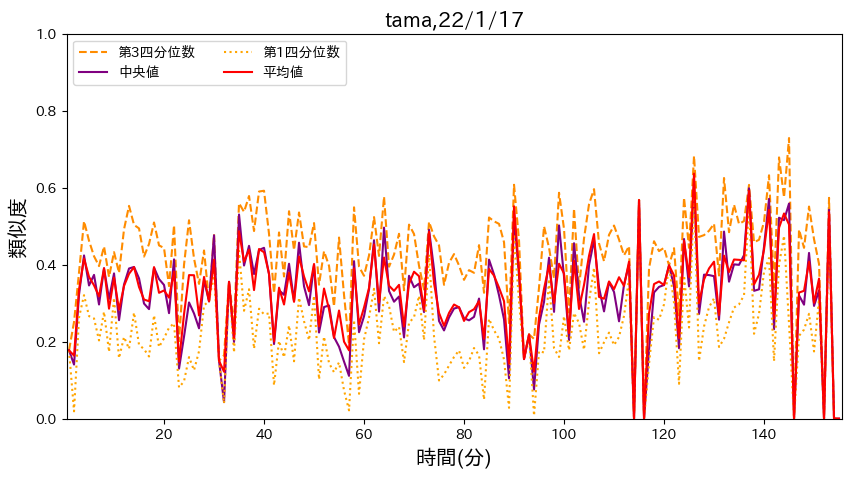

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/17", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


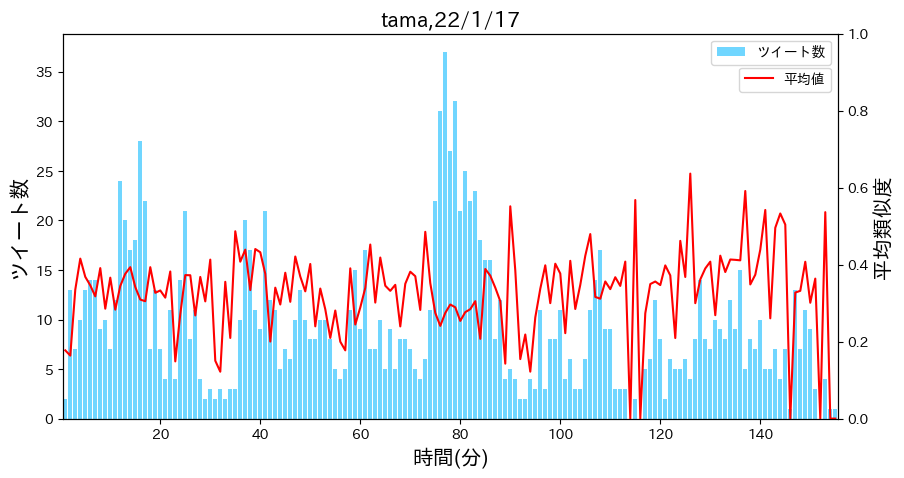

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/17", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


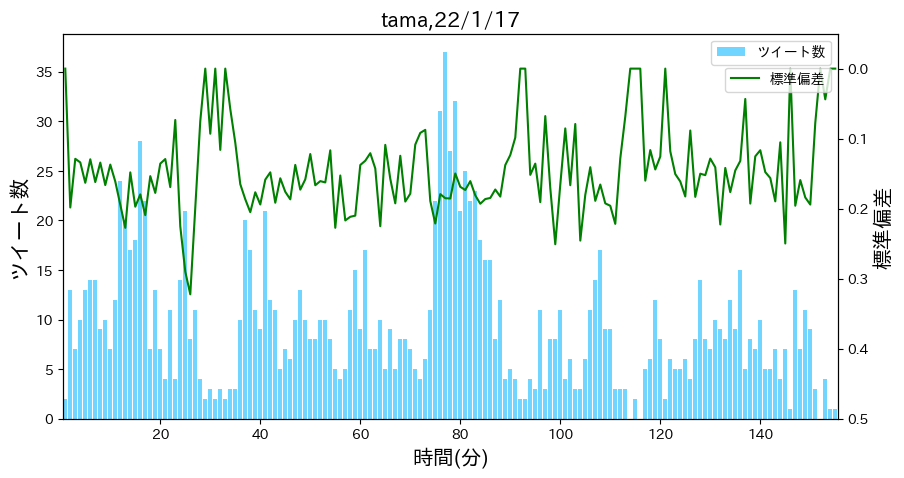

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "tama,22/1/17", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
